In [19]:
%matplotlib inline

### Preprocessing

#### Load data

In [8]:
import mne
import pandas as pd
import os
import copy

In [3]:
raw = mne.io.read_raw_fif('eeg_data/p1-raw.fif', preload=True)
raw.load_data()

Opening raw data file eeg_data/p1-raw.fif...
    Range : 0 ... 1214579 =      0.000 ...  1214.579 secs
Ready.
Reading 0 ... 1214579  =      0.000 ...  1214.579 secs...


<Raw | p1-raw.fif, 32 x 1214580 (1214.6 s), ~296.6 MB, data loaded>

In [33]:
#Marking channels that are bad - C3 is bad
raw.info['bads'] = ['C3']

#### Filtering

In [39]:
raw_filtered = raw.copy().filter(None, 40)
raw_filtered = raw_filtered.filter(0.1, None)

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 331 samples (0.331 sec)

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Filter length: 33001 samples (33.001 sec)



In [40]:
raw_filtered.info

<Info | 13 non-empty values
 bads: 1 items (C3)
 ch_names: Fp1, Fp2, F7, F3, Fz, F4, F8, FC5, FC1, FC2, FC6, T7, C3, Cz, ...
 chs: 32 EEG
 custom_ref_applied: False
 description: Anonymized using a time shift to preserve age at acquisition
 dig: 35 items (3 Cardinal, 32 EEG)
 experimenter: mne_anonymize
 file_id: 4 items (dict)
 highpass: 0.1 Hz
 lowpass: 40.0 Hz
 meas_date: 2000-01-01 00:00:00 UTC
 meas_id: 4 items (dict)
 nchan: 32
 projs: []
 sfreq: 1000.0 Hz
>

#### Visual inspection - bad channels?

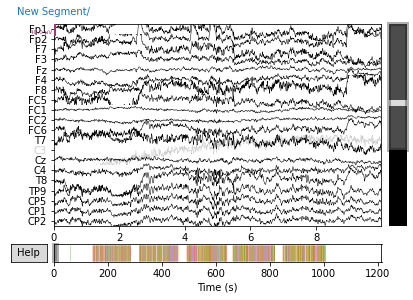

In [41]:
raw_filtered.plot();

P1: channels C3, FC5 look bad (have some drifts)

#### Artefact removal

##### ICA

By setting n_components=0.95, we let the ICA run until 95 % of variance is explained instead of manually deciding on number of components to use. 

Fitting ICA to data using 31 channels (please be patient, this may take a while)
Selecting by explained variance: 11 components
Fitting ICA took 14.3s.


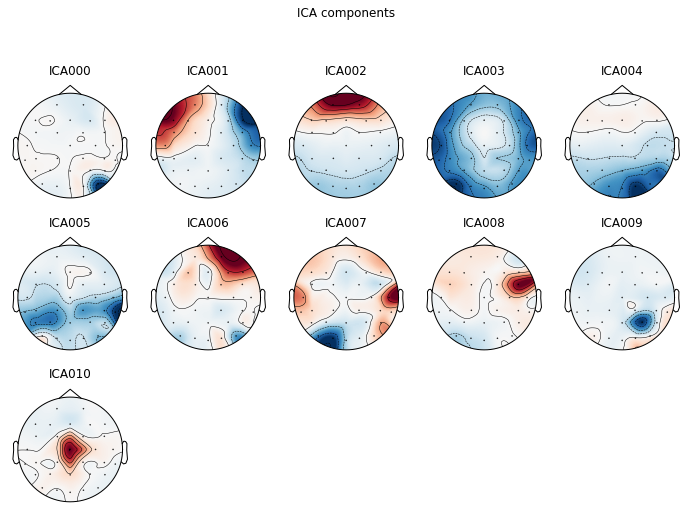

In [42]:
## set up and fit the ICA
ica = mne.preprocessing.ICA(n_components=0.95, random_state=97, max_iter=800)
ica.fit(raw_filtered)
## ica.exclude = [0, 2]  # details on how we picked these are omitted here
ica.plot_components(); #, picks=ica.exclude

Compoment 001 is almost definitely a saccade, while component 002 most likely is an eyeblink.

    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
Not setting metadata
607 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Not setting metadata
Not setting metadata
607 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Not setting metadata
Not setting metadata
607 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Not setting metadata
Not setting metadata
607 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Not setting metadata
Not setting metadata
607 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


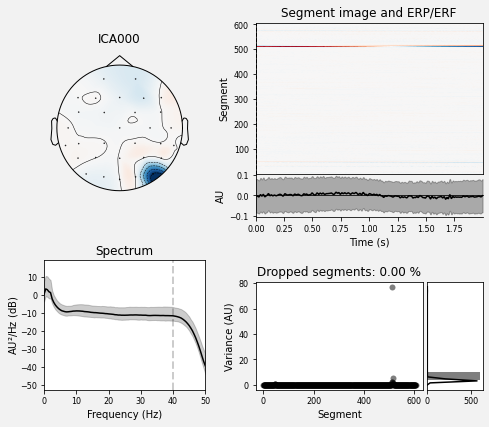

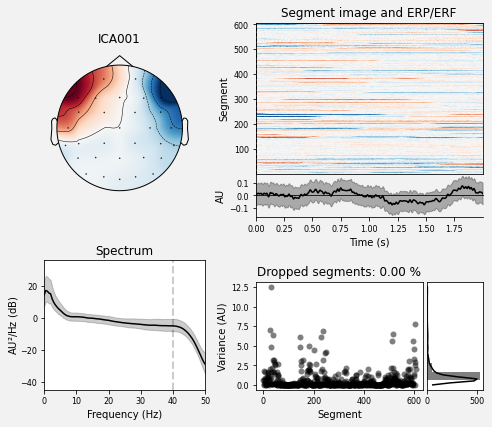

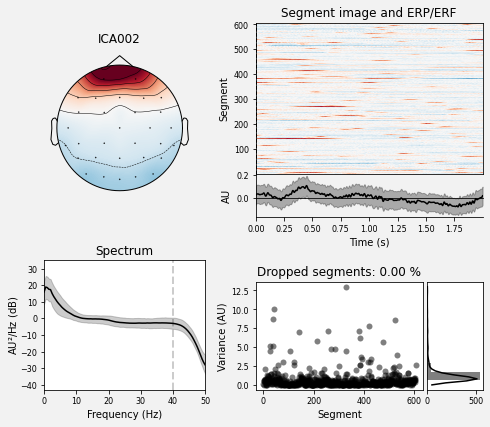

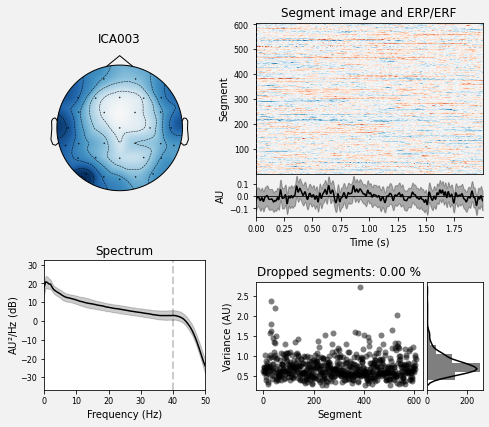

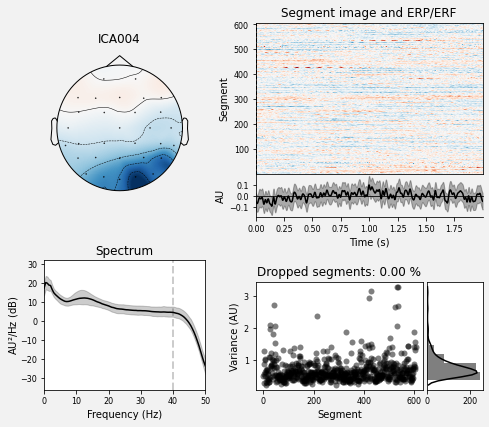

In [43]:
ica.plot_properties(raw_filtered); #, picks=ica.exclude

Creating RawArray with float64 data, n_channels=11, n_times=1214580
    Range : 0 ... 1214579 =      0.000 ...  1214.579 secs
Ready.


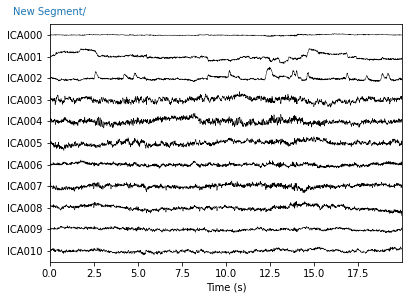

In [44]:
ica.plot_sources(raw_filtered, show_scrollbars=False);

This plot indicates, that component ICA000 is somehow a dead signal, while ICA001 again looks like a saccade due to the "boxes" in the signal. ICA002 could still likely be an eyeblink. I will therefore remove ICAs 000, 001 and 002.

In [46]:
filtered = raw_filtered.copy() #Making a copy of the filtered data to actually apply the ICA to. 
ica.exclude = [0, 1, 2]
ica.apply(filtered)

Applying ICA to Raw instance
    Transforming to ICA space (11 components)
    Zeroing out 3 ICA components
    Projecting back using 31 PCA components


<Raw | p1-raw.fif, 32 x 1214580 (1214.6 s), ~296.6 MB, data loaded>

#### Epoching

#### Event detection

In [ ]:
events, _ = mne.events_from_annotations(filtered) #We use events that are already included in the data
event_id = {'S20': 20, 'S11': 11, 'S10': 10} #Names for the event are defined

Non-RawBrainVision raw using branvision markers
Used Annotations descriptions: ['New Segment/', 'Stimulus/S  1', 'Stimulus/S 10', 'Stimulus/S 11', 'Stimulus/S 12', 'Stimulus/S 20']


<ipython-input-21-66690da57121>:1: RuntimeWarning: event 1 missing from event_id will be ignored
  mne.viz.plot_events(events[:50], sfreq=250, first_samp=raw.first_samp, event_id=event_id);
<ipython-input-21-66690da57121>:1: RuntimeWarning: event 12 missing from event_id will be ignored
  mne.viz.plot_events(events[:50], sfreq=250, first_samp=raw.first_samp, event_id=event_id);
<ipython-input-21-66690da57121>:1: RuntimeWarning: event 99999 missing from event_id will be ignored
  mne.viz.plot_events(events[:50], sfreq=250, first_samp=raw.first_samp, event_id=event_id);


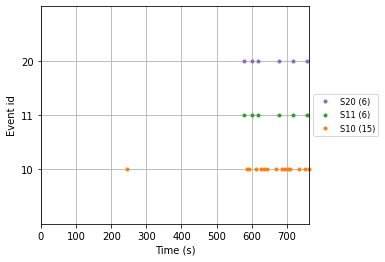

In [ ]:
mne.viz.plot_events(events[:50], sfreq=250, first_samp=filtered.first_samp, event_id=event_id); #Maybe dont do this???

In [ ]:
# Use tmin=0.55, tmax=1.55, baseline=(None,0) - tmin tmax is time before and after stimulus

In [54]:
reject_criteria = dict(eeg=150e-6)  #If any datapoints are above the 150 microVolt threshold, they are excluded
epochs = mne.Epochs(filtered, events, event_id,
                    baseline=(None,0), preload=True, 
                    tmin=-0.5, tmax=1.5, reject=reject_criteria)

Not setting metadata
Not setting metadata
439 matching events found
Setting baseline interval to [-0.5, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 439 events and 2001 original time points ...
    Rejecting  epoch based on EEG : ['P8', 'O2']
    Rejecting  epoch based on EEG : ['P4']
    Rejecting  epoch based on EEG : ['P4']
    Rejecting  epoch based on EEG : ['TP10']
4 bad epochs dropped


We see that 4 bad epochs are dropped based on the criteria defined. 

In [53]:
# epochs.equalize_event_counts() # We remove a lot of epochs if we do this

Dropped 141 epochs: 0, 4, 11, 12, 13, 17, 18, 22, 29, 33, 34, 38, 45, 46, 47, 51, 52, 53, 57, 70, 71, 72, 79, 83, 93, 94, 95, 96, 97, 98, 102, 109, 110, 114, 115, 119, 126, 127, 128, 135, 136, 137, 138, 139, 158, 165, 166, 173, 174, 175, 185, 192, 193, 194, 195, 196, 200, 201, 202, 203, 204, 205, 206, 210, 211, 212, 228, 235, 236, 237, 238, 239, 243, 253, 254, 255, 265, 266, 270, 274, 275, 276, 283, 284, 285, 286, 287, 288, 292, 299, 300, 304, 308, 309, 313, 317, 321, 328, 329, 330, 334, 335, 336, 337, 341, 342, 343, 347, 348, 358, 359, 363, 364, 368, 369, 370, 371, 375, 376, 377, 378, 379, 380, 381, 391, 395, 396, 400, 401, 405, 409, 413, 420, 421, 422, 426, 427, 428, 429, 433, 434


(<Epochs |  294 events (all good), -0.5 - 1.5 sec, baseline -0.5 – 0 sec, ~143.7 MB, data loaded,
  'S10': 98
  'S11': 98
  'S20': 98>,
 array([370,   0,   4,  11,  12,  13,  17,  18,  22,  29,  33,  34,  38,
         45,  46,  47,  51,  52,  53,  57,  70,  71,  72,  79,  83,  93,
         94,  95,  96,  97,  98, 102, 109, 110, 114, 115, 119, 126, 127,
        128, 135, 136, 137, 138, 139, 158, 165, 166, 173, 174, 175, 185,
        192, 193, 194, 195, 196, 200, 201, 202, 203, 204, 205, 206, 210,
        211, 212, 228, 235, 236, 237, 238, 239, 243, 253, 254, 255, 265,
        266, 270, 274, 275, 276, 283, 284, 285, 286, 287, 288, 292, 299,
        300, 304, 308, 309, 313, 317, 321, 328, 329, 330, 334, 335, 336,
        337, 341, 342, 343, 347, 348, 358, 359, 363, 364, 368, 369, 371,
        375, 376, 377, 378, 379, 380, 381, 391, 395, 396, 400, 401, 405,
        409, 413, 420, 421, 422, 426, 427, 428, 429, 433, 434], dtype=int64))

#### Trigger values on slide

20 is trial go 11 is response

#### Reject from values